# 데이터셋

## 데이터 불러오기

In [58]:
import os

def get_bearing_paths(root_dir):
    bearing_folders = []
    for root, dirs, files in os.walk(root_dir):
        for dir_name in dirs:
            if dir_name.startswith('Bearing'):
                try:
                    bearing_number = dir_name.split('Bearing')[1]
                    bearing_major, bearing_minor = map(int, bearing_number.split('_'))
                    if 1 <= bearing_major <= 3 and 1 <= bearing_minor <= 5:
                        bearing_folders.append(os.path.join(root, dir_name))
                except ValueError:
                    # 이름 형식이 맞지 않는 폴더는 무시
                    continue
    return bearing_folders

# 예시 루트 디렉토리
root_directory = ".\\datasets"
bearing_paths = get_bearing_paths(root_directory)

for path in bearing_paths:
    print(path)


.\datasets\35Hz12kN\Bearing1_1
.\datasets\35Hz12kN\Bearing1_2
.\datasets\35Hz12kN\Bearing1_3
.\datasets\35Hz12kN\Bearing1_4
.\datasets\35Hz12kN\Bearing1_5
.\datasets\37.5Hz11kN\Bearing2_1
.\datasets\37.5Hz11kN\Bearing2_2
.\datasets\37.5Hz11kN\Bearing2_3
.\datasets\37.5Hz11kN\Bearing2_4
.\datasets\37.5Hz11kN\Bearing2_5
.\datasets\40Hz10kN\Bearing3_1
.\datasets\40Hz10kN\Bearing3_2
.\datasets\40Hz10kN\Bearing3_3
.\datasets\40Hz10kN\Bearing3_4
.\datasets\40Hz10kN\Bearing3_5


In [1]:
import pandas as pd
import os
from tqdm import tqdm

data_path = "./datasets/37.5Hz11kN/Bearing2_4/" 
file_list = os.listdir(data_path)

file_list = sorted(file_list, key=lambda x: int(x.split('.')[0]))

df = pd.DataFrame()
for f in tqdm(file_list):
    temp = pd.read_csv(data_path + f"{f}")
    df = pd.concat([df, temp], axis=0)
df.reset_index(drop=True, inplace=True)
df

100%|██████████| 42/42 [00:00<00:00, 76.86it/s]


,Horizontal_vibration_signals,Vertical_vibration_signals
0,-0.502145,0.346816
1,0.015247,-0.053394
2,-0.804460,0.173879
3,-0.075197,0.779450
4,-0.140428,0.270998
...,...,...
1376251,5.612624,-1.017058
1376252,0.667703,1.832020
1376253,2.512228,-1.314712
1376254,5.813110,-3.424489


## 데이터 시각화

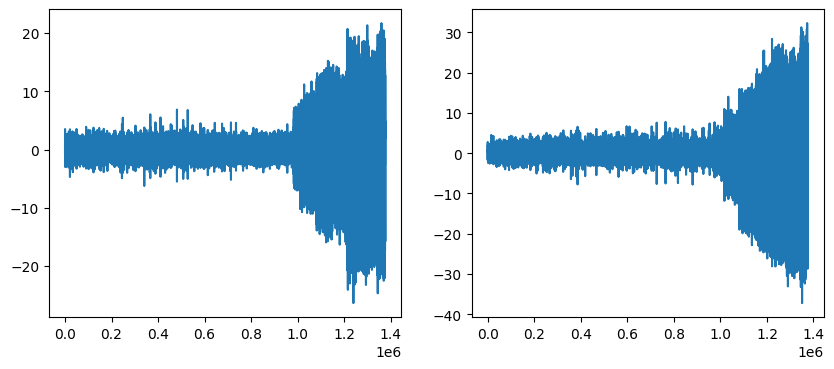

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
df["Horizontal_vibration_signals"].plot()

plt.subplot(1, 2, 2)
df["Vertical_vibration_signals"].plot()

plt.show()

## 데이터 전처리

In [3]:
n = len(df)

# RUL 값 할당
df['RUL'] = range(n-1, -1, -1)

# 최소값과 최대값 계산
min_rul = df['RUL'].min()
max_rul = df['RUL'].max()

# RUL 정규화 함수
def normalize_rul(rul, min_rul, max_rul):
    return (rul - min_rul) / (max_rul - min_rul)

# 정규화된 RUL 값 계산
df['Normalized_RUL'] = df['RUL'].apply(lambda x: normalize_rul(x, min_rul, max_rul))
df

,Horizontal_vibration_signals,Vertical_vibration_signals,RUL,Normalized_RUL
0,-0.502145,0.346816,1376255,1.000000e+00
1,0.015247,-0.053394,1376254,9.999993e-01
2,-0.804460,0.173879,1376253,9.999985e-01
3,-0.075197,0.779450,1376252,9.999978e-01
4,-0.140428,0.270998,1376251,9.999971e-01
...,...,...,...,...
1376251,5.612624,-1.017058,4,2.906438e-06
1376252,0.667703,1.832020,3,2.179829e-06
1376253,2.512228,-1.314712,2,1.453219e-06
1376254,5.813110,-3.424489,1,7.266095e-07


## 데이터셋 정의

In [4]:
import torch 
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader

class BearingDataset(Dataset):
    def __init__(self, vibration, rul, seq_length):
        self.vibration = vibration
        self.rul = rul
        self.seq_length = seq_length

    def __len__(self):
        return len(self.rul) - self.seq_length + 1

    def __getitem__(self, idx):
        x = self.vibration[idx:idx + self.seq_length]
        y = self.rul[idx + self.seq_length - 1]

        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)

        return x, y

In [15]:
# 사용 feature와 label을 분리
vibration = df[['Horizontal_vibration_signals', 'Vertical_vibration_signals']].values
rul_model = df['Normalized_RUL'].values

seq_length = 128  # 시퀀스 길이 설정
dataset = BearingDataset(vibration, rul_model, seq_length)
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)

# 모델

## RUL 예측 모델

In [16]:
import torch
import torch.nn as nn

class ResConv1dBlock(nn.Module):
    def __init__(self, channels):
        super(ResConv1dBlock, self).__init__()
        self.conv1 = nn.Conv1d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.norm1 = nn.InstanceNorm1d(channels)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        out = self.conv1(x)
        out = self.norm1(out)
        out = out + x
        out = self.relu(out)
        return out

class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, seq_length, device):
        super(BiLSTM, self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_length = seq_length
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, bidirectional=True, device=device)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(self.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.relu(out)
        return out

class Regressor(nn.Module):
    def __init__(self, input_size, device):
        super(Regressor, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 16, device=device)
        self.fc3 = nn.Linear(16, 1, device=device)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        out = self.fc1(x[:, -1, :])
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

class DegradationModel(nn.Module):
    def __init__(self, input_channels=2, hidden_size=64, num_layers=4, seq_length=128, device=torch.device("cuda")):
        super(DegradationModel, self).__init__()
        self.conv = ResConv1dBlock(input_channels)
        self.bilstm = BiLSTM(input_channels, hidden_size, num_layers, seq_length, device)
        self.reg = Regressor(hidden_size*2, device=device)
        self.device = device

    def forward(self, x):
        x = self.conv(x.permute(0,2,1))
        x = self.bilstm(x.permute(0,2,1))
        out = self.reg(x)
        return out

## 모델 학습

In [17]:
import torch.optim as optim
from tqdm import tqdm
import torch.nn.functional as F

ver = "1"

# 모델 초기화
input_channels = 2  # 입력 데이터의 특성 수 (진동 신호의 특성 수)
hidden_size = 64  # LSTM hidden state의 크기
num_layers = 4  # LSTM layer의 개수
device = torch.device('cuda')

rul_model = DegradationModel(input_channels, hidden_size, 
                                     num_layers, seq_length, device).to(device)

# 손실 함수 및 옵티마이저 정의
def loss_function(pred, target):
    loss = F.mse_loss(pred, target, reduction='mean')
    rmse_loss = torch.sqrt(loss)
    return rmse_loss

criterion = loss_function
optimizer = optim.AdamW(rul_model.parameters(), lr=0.001)

# 로그 파일 초기화
log_file = f'rul_log_{ver}.txt'
with open(log_file, 'w') as f:
    f.write("Training Log\n")

In [18]:
# 학습
num_epochs = 1000
for epoch in range(1, num_epochs+1):
    rul_model.train()
    total_loss = 0.0

    for batch in tqdm(dataloader, desc=f"Epoch: {epoch}"):
        x, y = batch
        x, y = x.to(device), y.view(-1,1).to(device)

        # 모델 예측
        pred = rul_model(x)

        # 손실 계산
        loss = criterion(pred, y)

        # 역전파 및 옵티마이저 스텝
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    log_message = f'Epoch {epoch}/{num_epochs}, Loss: {avg_loss}\n'
    print(log_message)

    # 로그 파일에 기록
    with open(log_file, 'a') as f:
        f.write(log_message)

Epoch: 1: 100%|██████████| 1344/1344 [01:07<00:00, 19.87it/s]


Epoch 1/1000, Loss: 0.16406739809151208



Epoch: 2: 100%|██████████| 1344/1344 [01:08<00:00, 19.70it/s]


Epoch 2/1000, Loss: 0.14692160510458052



Epoch: 3: 100%|██████████| 1344/1344 [01:07<00:00, 19.91it/s]


Epoch 3/1000, Loss: 0.1369759275167737



Epoch: 4: 100%|██████████| 1344/1344 [01:07<00:00, 19.96it/s]


Epoch 4/1000, Loss: 0.11762973582482941



Epoch: 5: 100%|██████████| 1344/1344 [01:06<00:00, 20.11it/s]


Epoch 5/1000, Loss: 0.08787510246371052



Epoch: 6: 100%|██████████| 1344/1344 [01:07<00:00, 20.05it/s]


Epoch 6/1000, Loss: 0.06357183344274138



Epoch: 7: 100%|██████████| 1344/1344 [01:05<00:00, 20.58it/s]


Epoch 7/1000, Loss: 0.04950361196616931



Epoch: 8: 100%|██████████| 1344/1344 [01:06<00:00, 20.32it/s]


Epoch 8/1000, Loss: 0.04091743409489503



Epoch: 9: 100%|██████████| 1344/1344 [01:05<00:00, 20.49it/s]


Epoch 9/1000, Loss: 0.03548589844666865



Epoch: 10: 100%|██████████| 1344/1344 [01:05<00:00, 20.39it/s]


Epoch 10/1000, Loss: 0.03189914468315519



Epoch: 11: 100%|██████████| 1344/1344 [01:05<00:00, 20.54it/s]


Epoch 11/1000, Loss: 0.028442258286910754



Epoch: 12: 100%|██████████| 1344/1344 [01:05<00:00, 20.50it/s]


Epoch 12/1000, Loss: 0.02807431913069671



Epoch: 13: 100%|██████████| 1344/1344 [01:06<00:00, 20.34it/s]


Epoch 13/1000, Loss: 0.03268746351352006



Epoch: 14: 100%|██████████| 1344/1344 [01:06<00:00, 20.20it/s]


Epoch 14/1000, Loss: 0.029089087070176555



Epoch: 15: 100%|██████████| 1344/1344 [01:06<00:00, 20.27it/s]


Epoch 15/1000, Loss: 0.023371426498107167



Epoch: 16: 100%|██████████| 1344/1344 [01:07<00:00, 19.85it/s]


Epoch 16/1000, Loss: 0.021717391371826773



Epoch: 17: 100%|██████████| 1344/1344 [01:06<00:00, 20.21it/s]


Epoch 17/1000, Loss: 0.020708867481776645



Epoch: 18: 100%|██████████| 1344/1344 [01:06<00:00, 20.23it/s]


Epoch 18/1000, Loss: 0.020332529009985074



Epoch: 19: 100%|██████████| 1344/1344 [01:06<00:00, 20.35it/s]


Epoch 19/1000, Loss: 0.022022852800243225



Epoch: 20: 100%|██████████| 1344/1344 [01:06<00:00, 20.09it/s]


Epoch 20/1000, Loss: 0.027388177972863473



Epoch: 21: 100%|██████████| 1344/1344 [01:06<00:00, 20.24it/s]


Epoch 21/1000, Loss: 0.01748916895511294



Epoch: 22: 100%|██████████| 1344/1344 [01:07<00:00, 19.93it/s]


Epoch 22/1000, Loss: 0.019663679832038247



Epoch: 23: 100%|██████████| 1344/1344 [01:08<00:00, 19.72it/s]


Epoch 23/1000, Loss: 0.019778912787192633



Epoch: 24: 100%|██████████| 1344/1344 [01:08<00:00, 19.67it/s]


Epoch 24/1000, Loss: 0.01597132420075858



Epoch: 25: 100%|██████████| 1344/1344 [01:08<00:00, 19.76it/s]


Epoch 25/1000, Loss: 0.02566760124630361



Epoch: 26: 100%|██████████| 1344/1344 [01:08<00:00, 19.59it/s]


Epoch 26/1000, Loss: 0.014307442954824572



Epoch: 27: 100%|██████████| 1344/1344 [01:07<00:00, 19.79it/s]


Epoch 27/1000, Loss: 0.018204500618074753



Epoch: 28: 100%|██████████| 1344/1344 [01:08<00:00, 19.76it/s]


Epoch 28/1000, Loss: 0.021641297202828962



Epoch: 29: 100%|██████████| 1344/1344 [01:07<00:00, 19.98it/s]


Epoch 29/1000, Loss: 0.012839795568392478



Epoch: 30: 100%|██████████| 1344/1344 [01:06<00:00, 20.27it/s]


Epoch 30/1000, Loss: 0.028506563334736883



Epoch: 31: 100%|██████████| 1344/1344 [01:06<00:00, 20.29it/s]


Epoch 31/1000, Loss: 0.012565542335367007



Epoch: 32: 100%|██████████| 1344/1344 [01:06<00:00, 20.07it/s]


Epoch 32/1000, Loss: 0.020290058716671496



Epoch: 33: 100%|██████████| 1344/1344 [01:07<00:00, 19.77it/s]


Epoch 33/1000, Loss: 0.01193984585933365



Epoch: 34: 100%|██████████| 1344/1344 [01:07<00:00, 20.05it/s]


Epoch 34/1000, Loss: 0.018406314681799683



Epoch: 35: 100%|██████████| 1344/1344 [01:08<00:00, 19.71it/s]


Epoch 35/1000, Loss: 0.01910943175815711



Epoch: 36: 100%|██████████| 1344/1344 [01:07<00:00, 19.87it/s]


Epoch 36/1000, Loss: 0.01404283576578434



Epoch: 37: 100%|██████████| 1344/1344 [01:08<00:00, 19.64it/s]


Epoch 37/1000, Loss: 0.010922909457890671



Epoch: 38: 100%|██████████| 1344/1344 [01:06<00:00, 20.26it/s]


Epoch 38/1000, Loss: 0.021039863901456728



Epoch: 39: 100%|██████████| 1344/1344 [01:06<00:00, 20.27it/s]


Epoch 39/1000, Loss: 0.010859337415673681



Epoch: 40: 100%|██████████| 1344/1344 [01:06<00:00, 20.14it/s]


Epoch 40/1000, Loss: 0.011934040455907095



Epoch: 41: 100%|██████████| 1344/1344 [01:06<00:00, 20.18it/s]


Epoch 41/1000, Loss: 0.018424599804954294



Epoch: 42: 100%|██████████| 1344/1344 [01:06<00:00, 20.15it/s]


Epoch 42/1000, Loss: 0.01877843095557875



Epoch: 43: 100%|██████████| 1344/1344 [01:06<00:00, 20.20it/s]


Epoch 43/1000, Loss: 0.00966005984810181



Epoch: 44: 100%|██████████| 1344/1344 [01:05<00:00, 20.47it/s]


Epoch 44/1000, Loss: 0.009837976223068489



Epoch: 45: 100%|██████████| 1344/1344 [01:05<00:00, 20.40it/s]


Epoch 45/1000, Loss: 0.019818348655549232



Epoch: 46: 100%|██████████| 1344/1344 [01:06<00:00, 20.34it/s]


Epoch 46/1000, Loss: 0.00917075623250899



Epoch: 47: 100%|██████████| 1344/1344 [01:07<00:00, 20.05it/s]


Epoch 47/1000, Loss: 0.011615353631592976



Epoch: 48: 100%|██████████| 1344/1344 [01:06<00:00, 20.21it/s]


Epoch 48/1000, Loss: 0.01636143937953637



Epoch: 49: 100%|██████████| 1344/1344 [01:06<00:00, 20.21it/s]


Epoch 49/1000, Loss: 0.01637069504448889



Epoch: 50: 100%|██████████| 1344/1344 [01:06<00:00, 20.20it/s]


Epoch 50/1000, Loss: 0.008679469187059329



Epoch: 51: 100%|██████████| 1344/1344 [01:06<00:00, 20.23it/s]


Epoch 51/1000, Loss: 0.014575843116506889



Epoch: 52: 100%|██████████| 1344/1344 [01:07<00:00, 20.04it/s]


Epoch 52/1000, Loss: 0.014528012600272805



Epoch: 53: 100%|██████████| 1344/1344 [01:06<00:00, 20.31it/s]


Epoch 53/1000, Loss: 0.008208268424260453



Epoch: 54: 100%|██████████| 1344/1344 [01:06<00:00, 20.31it/s]


Epoch 54/1000, Loss: 0.008676511594482387



Epoch: 55: 100%|██████████| 1344/1344 [01:06<00:00, 20.27it/s]


Epoch 55/1000, Loss: 0.01866992472475561



Epoch: 56: 100%|██████████| 1344/1344 [01:06<00:00, 20.22it/s]


Epoch 56/1000, Loss: 0.018042278848865646



Epoch: 57: 100%|██████████| 1344/1344 [01:06<00:00, 20.10it/s]


Epoch 57/1000, Loss: 0.01133370791060207



Epoch: 58: 100%|██████████| 1344/1344 [01:06<00:00, 20.27it/s]


Epoch 58/1000, Loss: 0.007900943419372197



Epoch: 59: 100%|██████████| 1344/1344 [01:06<00:00, 20.33it/s]


Epoch 59/1000, Loss: 0.020473017794540197



Epoch: 60: 100%|██████████| 1344/1344 [01:06<00:00, 20.09it/s]


Epoch 60/1000, Loss: 0.007626957976927294



Epoch: 61: 100%|██████████| 1344/1344 [01:06<00:00, 20.31it/s]


Epoch 61/1000, Loss: 0.007969980264620279



Epoch: 62: 100%|██████████| 1344/1344 [01:06<00:00, 20.31it/s]


Epoch 62/1000, Loss: 0.024512143488945662



Epoch: 63: 100%|██████████| 1344/1344 [01:05<00:00, 20.38it/s]


Epoch 63/1000, Loss: 0.007668887981535157



Epoch: 64: 100%|██████████| 1344/1344 [01:06<00:00, 20.15it/s]


Epoch 64/1000, Loss: 0.007442409630000059



Epoch: 65: 100%|██████████| 1344/1344 [01:06<00:00, 20.32it/s]


Epoch 65/1000, Loss: 0.01667102500851754



Epoch: 66: 100%|██████████| 1344/1344 [01:05<00:00, 20.38it/s]


Epoch 66/1000, Loss: 0.009732681960269388



Epoch: 67: 100%|██████████| 1344/1344 [01:06<00:00, 20.32it/s]


Epoch 67/1000, Loss: 0.00707703085763136



Epoch: 68: 100%|██████████| 1344/1344 [01:07<00:00, 20.03it/s]


Epoch 68/1000, Loss: 0.01657565278236732



Epoch: 69: 100%|██████████| 1344/1344 [01:06<00:00, 20.14it/s]


Epoch 69/1000, Loss: 0.0069305176082361



Epoch: 70: 100%|██████████| 1344/1344 [01:06<00:00, 20.16it/s]


Epoch 70/1000, Loss: 0.007277476888876187



Epoch: 71: 100%|██████████| 1344/1344 [01:06<00:00, 20.18it/s]


Epoch 71/1000, Loss: 0.02267125084680239



Epoch: 72: 100%|██████████| 1344/1344 [01:05<00:00, 20.43it/s]


Epoch 72/1000, Loss: 0.006777604782698853



Epoch: 73: 100%|██████████| 1344/1344 [01:05<00:00, 20.41it/s]


Epoch 73/1000, Loss: 0.006790345112330258



Epoch: 74: 100%|██████████| 1344/1344 [01:06<00:00, 20.29it/s]


Epoch 74/1000, Loss: 0.01822695196148873



Epoch: 75: 100%|██████████| 1344/1344 [01:07<00:00, 19.97it/s]


Epoch 75/1000, Loss: 0.01675871445886081



Epoch: 76: 100%|██████████| 1344/1344 [01:07<00:00, 20.00it/s]


Epoch 76/1000, Loss: 0.006767925341721691



Epoch: 77: 100%|██████████| 1344/1344 [01:06<00:00, 20.12it/s]


Epoch 77/1000, Loss: 0.014461347783729988



Epoch: 78: 100%|██████████| 1344/1344 [01:06<00:00, 20.30it/s]


Epoch 78/1000, Loss: 0.014289298666491439



Epoch: 79: 100%|██████████| 1344/1344 [01:06<00:00, 20.33it/s]


Epoch 79/1000, Loss: 0.006370583412977534



Epoch: 80: 100%|██████████| 1344/1344 [01:06<00:00, 20.16it/s]


Epoch 80/1000, Loss: 0.006621690183237661



Epoch: 81: 100%|██████████| 1344/1344 [01:06<00:00, 20.17it/s]


Epoch 81/1000, Loss: 0.019041882506003492



Epoch: 82: 100%|██████████| 1344/1344 [01:06<00:00, 20.28it/s]


Epoch 82/1000, Loss: 0.008014377006648352



Epoch: 83: 100%|██████████| 1344/1344 [01:06<00:00, 20.16it/s]


Epoch 83/1000, Loss: 0.006133120128305606



Epoch: 84: 100%|██████████| 1344/1344 [01:06<00:00, 20.13it/s]


Epoch 84/1000, Loss: 0.0067879232942470395



Epoch: 85: 100%|██████████| 1344/1344 [01:06<00:00, 20.20it/s]


Epoch 85/1000, Loss: 0.013175074710965245



Epoch: 86: 100%|██████████| 1344/1344 [01:06<00:00, 20.34it/s]


Epoch 86/1000, Loss: 0.017769324224597465



Epoch: 87: 100%|██████████| 1344/1344 [01:07<00:00, 20.00it/s]


Epoch 87/1000, Loss: 0.01480455320207901



Epoch: 88: 100%|██████████| 1344/1344 [01:06<00:00, 20.26it/s]


Epoch 88/1000, Loss: 0.006263542544426552



Epoch: 89: 100%|██████████| 1344/1344 [01:06<00:00, 20.26it/s]


Epoch 89/1000, Loss: 0.018421474400383886



Epoch: 90: 100%|██████████| 1344/1344 [01:05<00:00, 20.39it/s]


Epoch 90/1000, Loss: 0.006337199662604169



Epoch: 91: 100%|██████████| 1344/1344 [01:06<00:00, 20.19it/s]


Epoch 91/1000, Loss: 0.00592470804466367



Epoch: 92: 100%|██████████| 1344/1344 [01:06<00:00, 20.27it/s]


Epoch 92/1000, Loss: 0.006344993851338846



Epoch: 93: 100%|██████████| 1344/1344 [01:06<00:00, 20.21it/s]


Epoch 93/1000, Loss: 0.02292413500946991



Epoch: 94: 100%|██████████| 1344/1344 [01:05<00:00, 20.41it/s]


Epoch 94/1000, Loss: 0.01554304100101858



Epoch: 95: 100%|██████████| 1344/1344 [01:06<00:00, 20.30it/s]


Epoch 95/1000, Loss: 0.005997459814742407



Epoch: 96: 100%|██████████| 1344/1344 [01:06<00:00, 20.30it/s]


Epoch 96/1000, Loss: 0.005728614039114854



Epoch: 97: 100%|██████████| 1344/1344 [01:06<00:00, 20.11it/s]


Epoch 97/1000, Loss: 0.016948182250849812



Epoch: 98: 100%|██████████| 1344/1344 [01:06<00:00, 20.17it/s]


Epoch 98/1000, Loss: 0.0057815298201776815



Epoch: 99: 100%|██████████| 1344/1344 [01:06<00:00, 20.25it/s]


Epoch 99/1000, Loss: 0.00564242572623438



Epoch: 100: 100%|██████████| 1344/1344 [01:06<00:00, 20.18it/s]


Epoch 100/1000, Loss: 0.018313241383155054



Epoch: 101: 100%|██████████| 1344/1344 [01:06<00:00, 20.22it/s]


Epoch 101/1000, Loss: 0.006246296802904301



Epoch: 102: 100%|██████████| 1344/1344 [01:06<00:00, 20.12it/s]


Epoch 102/1000, Loss: 0.005428444021076541



Epoch: 103: 100%|██████████| 1344/1344 [01:06<00:00, 20.35it/s]


Epoch 103/1000, Loss: 0.00583040423190964



Epoch: 104: 100%|██████████| 1344/1344 [01:06<00:00, 20.14it/s]


Epoch 104/1000, Loss: 0.02505083213847164



Epoch: 105: 100%|██████████| 1344/1344 [01:06<00:00, 20.28it/s]


Epoch 105/1000, Loss: 0.006096990696927865



Epoch: 106: 100%|██████████| 1344/1344 [01:05<00:00, 20.42it/s]


Epoch 106/1000, Loss: 0.0084266318593845



Epoch: 107: 100%|██████████| 1344/1344 [01:06<00:00, 20.29it/s]


Epoch 107/1000, Loss: 0.01489700322313833



Epoch: 108: 100%|██████████| 1344/1344 [01:06<00:00, 20.13it/s]


Epoch 108/1000, Loss: 0.016262356138863003



Epoch: 109: 100%|██████████| 1344/1344 [01:06<00:00, 20.35it/s]


Epoch 109/1000, Loss: 0.008734498217000649



Epoch: 110: 100%|██████████| 1344/1344 [01:06<00:00, 20.29it/s]


Epoch 110/1000, Loss: 0.005268967952967311



Epoch: 111: 100%|██████████| 1344/1344 [01:06<00:00, 20.20it/s]


Epoch 111/1000, Loss: 0.018690846029563717



Epoch: 112: 100%|██████████| 1344/1344 [01:06<00:00, 20.14it/s]


Epoch 112/1000, Loss: 0.005775720267722916



Epoch: 113: 100%|██████████| 1344/1344 [01:06<00:00, 20.19it/s]


Epoch 113/1000, Loss: 0.005295799750283116



Epoch: 114: 100%|██████████| 1344/1344 [01:06<00:00, 20.29it/s]


Epoch 114/1000, Loss: 0.014972720431701635



Epoch: 115: 100%|██████████| 1344/1344 [01:05<00:00, 20.38it/s]


Epoch 115/1000, Loss: 0.01678115272633953



Epoch: 116: 100%|██████████| 1344/1344 [01:06<00:00, 20.25it/s]


Epoch 116/1000, Loss: 0.005625544603043679



Epoch: 117: 100%|██████████| 1344/1344 [01:06<00:00, 20.31it/s]


Epoch 117/1000, Loss: 0.005118817494284096



Epoch: 118: 100%|██████████| 1344/1344 [01:06<00:00, 20.25it/s]


Epoch 118/1000, Loss: 0.02295249739178135



Epoch: 119: 100%|██████████| 1344/1344 [01:06<00:00, 20.33it/s]


Epoch 119/1000, Loss: 0.006939458329205601



Epoch: 120: 100%|██████████| 1344/1344 [01:06<00:00, 20.21it/s]


Epoch 120/1000, Loss: 0.00505824125658754



Epoch: 121: 100%|██████████| 1344/1344 [01:06<00:00, 20.14it/s]


Epoch 121/1000, Loss: 0.005295116967491118



Epoch: 122: 100%|██████████| 1344/1344 [01:06<00:00, 20.21it/s]


Epoch 122/1000, Loss: 0.005640821875810313



Epoch: 123: 100%|██████████| 1344/1344 [01:06<00:00, 20.16it/s]


Epoch 123/1000, Loss: 0.02641363285199207



Epoch: 124: 100%|██████████| 1344/1344 [01:06<00:00, 20.26it/s]


Epoch 124/1000, Loss: 0.008917605380355824



Epoch: 125: 100%|██████████| 1344/1344 [01:07<00:00, 19.99it/s]


Epoch 125/1000, Loss: 0.004978372503717851



Epoch: 126: 100%|██████████| 1344/1344 [01:06<00:00, 20.10it/s]


Epoch 126/1000, Loss: 0.0049233097289245395



Epoch: 127: 100%|██████████| 1344/1344 [01:06<00:00, 20.06it/s]


Epoch 127/1000, Loss: 0.019616890262113884



Epoch: 128: 100%|██████████| 1344/1344 [01:07<00:00, 20.00it/s]


Epoch 128/1000, Loss: 0.006491929033516152



Epoch: 129: 100%|██████████| 1344/1344 [01:06<00:00, 20.34it/s]


Epoch 129/1000, Loss: 0.0047966205945288365



Epoch: 130: 100%|██████████| 1344/1344 [01:06<00:00, 20.16it/s]


Epoch 130/1000, Loss: 0.004925200126308482



Epoch: 131: 100%|██████████| 1344/1344 [01:06<00:00, 20.32it/s]


Epoch 131/1000, Loss: 0.02045853156076711



Epoch: 132: 100%|██████████| 1344/1344 [01:06<00:00, 20.33it/s]


Epoch 132/1000, Loss: 0.005147726110105093



Epoch: 133: 100%|██████████| 1344/1344 [01:06<00:00, 20.06it/s]


Epoch 133/1000, Loss: 0.004667782396219471



Epoch: 134: 100%|██████████| 1344/1344 [01:06<00:00, 20.26it/s]


Epoch 134/1000, Loss: 0.020346333496230988



Epoch: 135: 100%|██████████| 1344/1344 [01:06<00:00, 20.16it/s]


Epoch 135/1000, Loss: 0.012909789961884684



Epoch: 136: 100%|██████████| 1344/1344 [01:06<00:00, 20.17it/s]


Epoch 136/1000, Loss: 0.004851471441811771



Epoch: 137: 100%|██████████| 1344/1344 [01:06<00:00, 20.34it/s]


Epoch 137/1000, Loss: 0.006183809671797678



Epoch: 138: 100%|██████████| 1344/1344 [01:07<00:00, 20.04it/s]


Epoch 138/1000, Loss: 0.01910807593611978



Epoch: 139: 100%|██████████| 1344/1344 [01:06<00:00, 20.22it/s]


Epoch 139/1000, Loss: 0.004928148410856791



Epoch: 140: 100%|██████████| 1344/1344 [01:06<00:00, 20.19it/s]


Epoch 140/1000, Loss: 0.009504173738518841



Epoch: 141: 100%|██████████| 1344/1344 [01:07<00:00, 19.88it/s]


Epoch 141/1000, Loss: 0.010742949420611174



Epoch: 142: 100%|██████████| 1344/1344 [01:06<00:00, 20.29it/s]


Epoch 142/1000, Loss: 0.004575690073016588



Epoch: 143: 100%|██████████| 1344/1344 [01:06<00:00, 20.25it/s]


Epoch 143/1000, Loss: 0.01678521969352871



Epoch: 144: 100%|██████████| 1344/1344 [01:06<00:00, 20.11it/s]


Epoch 144/1000, Loss: 0.00742151628323232



Epoch: 145: 100%|██████████| 1344/1344 [01:06<00:00, 20.28it/s]


Epoch 145/1000, Loss: 0.004538094284292865



Epoch: 146: 100%|██████████| 1344/1344 [01:07<00:00, 20.06it/s]


Epoch 146/1000, Loss: 0.007103052965941883



Epoch: 147: 100%|██████████| 1344/1344 [01:07<00:00, 20.05it/s]


Epoch 147/1000, Loss: 0.01797632272722521



Epoch: 148: 100%|██████████| 1344/1344 [01:06<00:00, 20.19it/s]


Epoch 148/1000, Loss: 0.004806875380814918



Epoch: 149: 100%|██████████| 1344/1344 [01:08<00:00, 19.67it/s]


Epoch 149/1000, Loss: 0.004460588366263047



Epoch: 150: 100%|██████████| 1344/1344 [01:11<00:00, 18.83it/s]


Epoch 150/1000, Loss: 0.0047630099846477



Epoch: 151: 100%|██████████| 1344/1344 [01:09<00:00, 19.25it/s]


Epoch 151/1000, Loss: 0.005001821894048979



Epoch: 152: 100%|██████████| 1344/1344 [01:07<00:00, 20.05it/s]


Epoch 152/1000, Loss: 0.02319041675080024



Epoch: 153: 100%|██████████| 1344/1344 [01:06<00:00, 20.22it/s]


Epoch 153/1000, Loss: 0.00594412065159607



Epoch: 154: 100%|██████████| 1344/1344 [01:06<00:00, 20.22it/s]


Epoch 154/1000, Loss: 0.004270762384597522



Epoch: 155: 100%|██████████| 1344/1344 [01:06<00:00, 20.10it/s]


Epoch 155/1000, Loss: 0.008510693190536196



Epoch: 156: 100%|██████████| 1344/1344 [01:06<00:00, 20.14it/s]


Epoch 156/1000, Loss: 0.017936826252913478



Epoch: 157: 100%|██████████| 1344/1344 [01:06<00:00, 20.19it/s]


Epoch 157/1000, Loss: 0.00481499382260067



Epoch: 158: 100%|██████████| 1344/1344 [01:06<00:00, 20.14it/s]


Epoch 158/1000, Loss: 0.004236114297999025



Epoch: 159: 100%|██████████| 1344/1344 [01:06<00:00, 20.17it/s]


Epoch 159/1000, Loss: 0.018850962502689243



Epoch: 160: 100%|██████████| 1344/1344 [01:06<00:00, 20.12it/s]


Epoch 160/1000, Loss: 0.013547819907779783



Epoch: 161: 100%|██████████| 1344/1344 [01:06<00:00, 20.24it/s]


Epoch 161/1000, Loss: 0.00986904961679275



Epoch: 162: 100%|██████████| 1344/1344 [01:07<00:00, 19.98it/s]


Epoch 162/1000, Loss: 0.004479274466055878



Epoch: 163: 100%|██████████| 1344/1344 [01:06<00:00, 20.15it/s]


Epoch 163/1000, Loss: 0.004553066080136757



Epoch: 164: 100%|██████████| 1344/1344 [01:06<00:00, 20.23it/s]


Epoch 164/1000, Loss: 0.017999513198446948



Epoch: 165: 100%|██████████| 1344/1344 [01:07<00:00, 20.00it/s]


Epoch 165/1000, Loss: 0.004505444772976695



Epoch: 166: 100%|██████████| 1344/1344 [01:06<00:00, 20.20it/s]


Epoch 166/1000, Loss: 0.004218061540866204



Epoch: 167: 100%|██████████| 1344/1344 [01:06<00:00, 20.29it/s]


Epoch 167/1000, Loss: 0.01825281517830306



Epoch: 168: 100%|██████████| 1344/1344 [01:06<00:00, 20.33it/s]


Epoch 168/1000, Loss: 0.011632222264389773



Epoch: 169: 100%|██████████| 1344/1344 [01:06<00:00, 20.29it/s]


Epoch 169/1000, Loss: 0.004482202152887892



Epoch: 170: 100%|██████████| 1344/1344 [01:06<00:00, 20.15it/s]


Epoch 170/1000, Loss: 0.004233310355803475



Epoch: 171: 100%|██████████| 1344/1344 [01:06<00:00, 20.19it/s]


Epoch 171/1000, Loss: 0.018158896597014973



Epoch: 172: 100%|██████████| 1344/1344 [01:06<00:00, 20.16it/s]


Epoch 172/1000, Loss: 0.009820021817826532



Epoch: 173: 100%|██████████| 1344/1344 [01:06<00:00, 20.19it/s]


Epoch 173/1000, Loss: 0.004297492230675527



Epoch: 174: 100%|██████████| 1344/1344 [01:06<00:00, 20.23it/s]


Epoch 174/1000, Loss: 0.004130966059858024



Epoch: 175: 100%|██████████| 1344/1344 [01:05<00:00, 20.41it/s]


Epoch 175/1000, Loss: 0.019229149455246182



Epoch: 176: 100%|██████████| 1344/1344 [01:06<00:00, 20.26it/s]


Epoch 176/1000, Loss: 0.011108505896118004



Epoch: 177: 100%|██████████| 1344/1344 [01:06<00:00, 20.30it/s]


Epoch 177/1000, Loss: 0.004436760564463579



Epoch: 178: 100%|██████████| 1344/1344 [01:06<00:00, 20.19it/s]


Epoch 178/1000, Loss: 0.004139084374314518



Epoch: 179: 100%|██████████| 1344/1344 [01:07<00:00, 19.88it/s]


Epoch 179/1000, Loss: 0.004295026903751672



Epoch: 180: 100%|██████████| 1344/1344 [01:06<00:00, 20.23it/s]


Epoch 180/1000, Loss: 0.012774728741663108



Epoch: 181: 100%|██████████| 1344/1344 [01:06<00:00, 20.32it/s]


Epoch 181/1000, Loss: 0.014109603069387265



Epoch: 182: 100%|██████████| 1344/1344 [01:06<00:00, 20.25it/s]


Epoch 182/1000, Loss: 0.0045209819386183795



Epoch: 183: 100%|██████████| 1344/1344 [01:06<00:00, 20.25it/s]


Epoch 183/1000, Loss: 0.014756445893345656



Epoch: 184: 100%|██████████| 1344/1344 [01:07<00:00, 19.98it/s]


Epoch 184/1000, Loss: 0.004855242137723724



Epoch: 185: 100%|██████████| 1344/1344 [01:07<00:00, 20.05it/s]


Epoch 185/1000, Loss: 0.009432117203513848



Epoch: 186: 100%|██████████| 1344/1344 [01:06<00:00, 20.16it/s]


Epoch 186/1000, Loss: 0.011055874111965144



Epoch: 187: 100%|██████████| 1344/1344 [01:06<00:00, 20.10it/s]


Epoch 187/1000, Loss: 0.004042661064020302



Epoch: 188: 100%|██████████| 1344/1344 [01:06<00:00, 20.18it/s]


Epoch 188/1000, Loss: 0.003987201681801318



Epoch: 189: 100%|██████████| 1344/1344 [01:07<00:00, 19.89it/s]


Epoch 189/1000, Loss: 0.004245279386460814



Epoch: 190: 100%|██████████| 1344/1344 [01:06<00:00, 20.30it/s]


Epoch 190/1000, Loss: 0.01506970111343738



Epoch: 191: 100%|██████████| 1344/1344 [01:06<00:00, 20.31it/s]


Epoch 191/1000, Loss: 0.013058465907566383



Epoch: 192: 100%|██████████| 1344/1344 [01:06<00:00, 20.28it/s]


Epoch 192/1000, Loss: 0.004207611359258105



Epoch: 193: 100%|██████████| 1344/1344 [01:06<00:00, 20.18it/s]


Epoch 193/1000, Loss: 0.0037872895696810225



Epoch: 194: 100%|██████████| 1344/1344 [01:06<00:00, 20.07it/s]


Epoch 194/1000, Loss: 0.008135364595675907



Epoch: 195: 100%|██████████| 1344/1344 [01:07<00:00, 19.95it/s]


Epoch 195/1000, Loss: 0.013853289223680761



Epoch: 196:   4%|▍         | 59/1344 [00:03<01:06, 19.31it/s]


KeyboardInterrupt: 

## 모델 저장

In [19]:
# 학습된 모델 저장
torch.save(rul_model.state_dict(), f'./models/rul_model_{ver}.pth')

# 추론

## 모델 학습 Loss 시각화

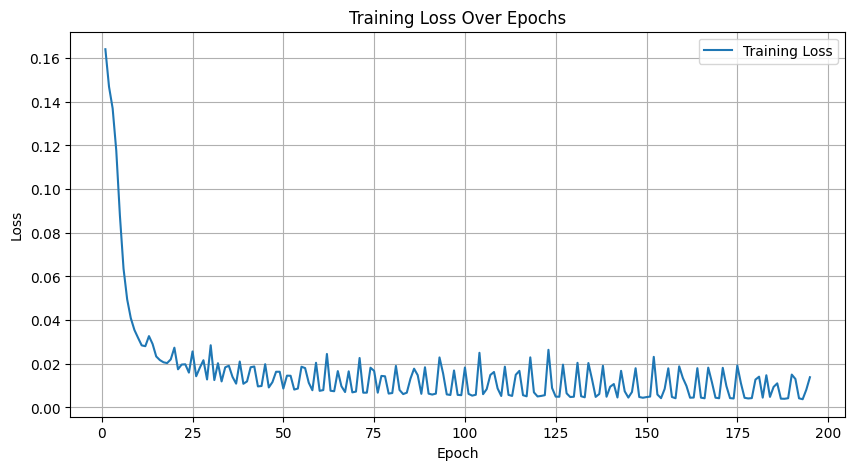

In [20]:
import matplotlib.pyplot as plt

# log.txt에서 손실 값 불러오기
log_file = f'rul_log_{ver}.txt'
epochs = []
losses = []

with open(log_file, 'r') as f:
    lines = f.readlines()[1:]  # 첫 번째 줄은 'Training Log'이므로 생략
    for line in lines:
        epoch_info = line.strip().split(',')
        epoch = int(epoch_info[0].split(' ')[1].split('/')[0])
        loss = float(epoch_info[1].split(': ')[1])
        epochs.append(epoch)
        losses.append(loss)

# 손실 값 시각화
plt.figure(figsize=(10, 5))
plt.plot(epochs, losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

## RUL 예측

In [36]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

def load_df(data_path):
    file_list = os.listdir(data_path)

    file_list = sorted(file_list, key=lambda x: int(x.split('.')[0]))

    df = pd.DataFrame()
    for f in tqdm(file_list):
        temp = pd.read_csv(data_path + f"{f}")
        df = pd.concat([df, temp], axis=0)
    df.reset_index(drop=True, inplace=True)

    # RUL 값 할당
    df['RUL'] = range(len(df)-1, -1, -1)

    # 최소값과 최대값 계산
    min_rul = df['RUL'].min()
    max_rul = df['RUL'].max()

    # RUL 정규화 함수 정의
    def normalize_rul(rul, min_rul, max_rul):
        return (rul - min_rul) / (max_rul - min_rul)

    # 정규화된 RUL 값 계산
    df['Normalized_RUL'] = df['RUL'].apply(lambda x: normalize_rul(x, min_rul, max_rul))
    
    return df

# Test Data
data_path = "./datasets/37.5Hz11kN/Bearing2_4/" 
df = load_df(data_path)

# 사용 feature와 label을 분리
vibration = df[['Horizontal_vibration_signals', 'Vertical_vibration_signals']].values
rul = df['Normalized_RUL'].values

seq_length = 128  # 시퀀스 길이 설정
dataset = BearingDataset(vibration, rul, seq_length)
dataloader = DataLoader(dataset, batch_size=1024, shuffle=False)

# 모델 정의
input_channels = 2  # 입력 데이터의 특성 수 (진동 신호의 특성 수)
hidden_size = 64  # LSTM hidden state의 크기
num_layers = 4  # LSTM layer의 개수
device = torch.device('cuda')

rul_model = DegradationModel(input_channels, hidden_size, 
                                     num_layers, seq_length, device).to(device)

# 학습된 모델 불러오기
model_path = f'models/rul_model_{ver}.pth'
rul_model.load_state_dict(torch.load(model_path))
rul_model.eval()

# 데이터셋에서 예측 수행
predicted_ruls = []
true_ruls = []

with torch.no_grad():
    for batch in tqdm(dataloader, desc="Testing..."):
        features, labels = batch
        features, labels = features.to(device), labels.view(-1,1).to(device)
        pred = rul_model(features)
        predicted_ruls.extend(pred.cpu().numpy())
        true_ruls.extend(labels.cpu().numpy())

predicted_ruls = np.array(predicted_ruls).flatten()
true_ruls = np.array(true_ruls).flatten()


Testing...: 100%|██████████| 1344/1344 [00:33<00:00, 40.66it/s]


In [37]:
predicted_ruls

array([0.99491274, 0.99552447, 0.9941093 , ..., 0.00423123, 0.00503178,
       0.00558287], dtype=float32)

## 예측된 RUL과 실제 RUL 비교

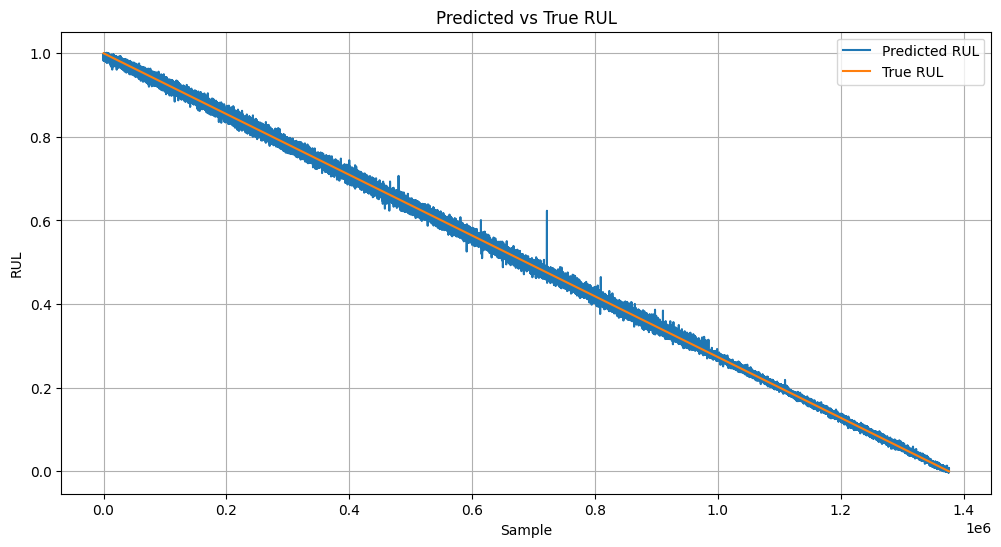

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# 예측된 RUL과 실제 라벨 시각화
plt.figure(figsize=(12, 6))
plt.plot(predicted_ruls, label='Predicted RUL')
plt.plot(true_ruls, label='True RUL')
plt.xlabel('Sample')
plt.ylabel('RUL')
plt.title('Predicted vs True RUL')
plt.legend()
plt.grid(True)
plt.show()
